In [1]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import joblib 

from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import lightgbm
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

import optuna
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 3126

In [3]:
train = pd.read_csv("/kaggle/input/sequence-level-broad-summary-features/train_features.csv")
test  = pl.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv")
test_demo  = pl.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv")

label_encoder = joblib.load("/kaggle/input/sequence-level-broad-summary-features/label_encoder.joblib")

# Baseline and Null Models Evaluation

In [4]:
from sklearn.metrics import f1_score

class ParticipantVisibleError(Exception):
    """Errors raised here will be shown directly to the competitor."""
    pass


class CompetitionMetric:
    """Hierarchical macro F1 for the CMI 2025 challenge."""
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]
        self.all_classes = self.target_gestures + self.non_target_gestures

    def calculate_hierarchical_f1(
        self,
        sol: pd.DataFrame,
        sub: pd.DataFrame
    ) -> float:

        # Validate gestures
        invalid_types = {i for i in sub['gesture'].unique() if i not in self.all_classes}
        if invalid_types:
            raise ParticipantVisibleError(
                f"Invalid gesture values in submission: {invalid_types}"
            )

        # Compute binary F1 (Target vs Non-Target)
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        
        f1_binary = f1_score(y_true_bin, y_pred_bin, pos_label=True, zero_division=0, average='binary')

        # Build multi-class labels for gestures
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')

        f1_macro = f1_score(y_true_mc, y_pred_mc, average='macro', zero_division=0)

        return f1_binary, f1_macro, (f1_binary+f1_macro)/2.0

In [5]:
def F1_score(y_val, y_pred, lbl_encoder, choice="weighted_score"):
    metric = CompetitionMetric()
    y_val  = pd.DataFrame({'id':range(len(y_val)), 
                           'gesture':y_val})
    y_pred = pd.DataFrame({'id':range(len(y_pred)), 
                           'gesture':y_pred})

    ## Convert numeric labels to original descriptions
    y_val["gesture"]  = lbl_encoder.inverse_transform(y_val["gesture"])
    y_pred["gesture"] = lbl_encoder.inverse_transform(y_pred["gesture"])

    ## Computes score
    binary, macro, weighted_score = metric.calculate_hierarchical_f1(y_val, y_pred)

    ## Returns result
    if choice=="binary": return binary
    elif choice=="macro": return macro
    elif choice=="weighted_score": return weighted_score
    else: return (binary, macro, weighted_score)

In [6]:
feature_cols = [col for col in train.columns 
                if col not in ['sequence_id', 'target', 'gesture', 'subject']]
X = train[feature_cols]
y = train["target"]

In [7]:
def cv_evaluate(model, model_kind, X, y, lbl_encoder, n_splits=5, 
                random_state=SEED, stopping_rounds=100, min_delta=.0005):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros_like(y)
    binary_scores   = []
    macro_scores    = []
    weighted_scores = []
    history = {}
    
    for fold_num,(train_fold, val_fold) in enumerate(skfold.split(X, y)):
        print(f"\nFold {fold_num + 1}/{n_splits}")
        X_train, y_train = X.iloc[train_fold], y[train_fold]
        X_val, y_val     = X.iloc[val_fold], y[val_fold]

        cloned_model = clone(model)

        if model_kind=="lgbm":
            cloned_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lightgbm.early_stopping(stopping_rounds=stopping_rounds, min_delta=min_delta)]
            )
        else:
            cloned_model.fit(X_train, y_train)
        ## Stores out-of-fold predictions
        y_pred = cloned_model.predict(X_val)
        oof_preds[val_fold] = y_pred
        
        ## Store cv scores
        binary, macro, weighted_score = F1_score(y_val, y_pred, lbl_encoder, choice=None)
        binary_scores.append(binary)
        macro_scores.append(macro)
        weighted_scores.append(weighted_score)
    
    ## Store cv results inside dict
    history["oof_preds"] = oof_preds
    history["binary_scores"] = binary_scores
    history["macro_scores"]  = macro_scores
    history["weighted_scores"] = weighted_scores

    ## Store oof prediction scores inside dict
    binary, macro, weighted_score = F1_score(y, oof_preds, lbl_encoder, choice=None)
    history["full_binary_score"] = binary
    history["full_macro_score"] = macro
    history["full_weighted_score"] = weighted_score
    return history

In [8]:
params = {"n_estimators":2000,
          "max_depth":10,
          "learning_rate":.075,
          "colsample_bytree":.75,
          "subsample":.75
}
params["class_weight"] = "balanced"
params["objective"] = "multiclass"
params["n_jobs"] = -1
params["verbose"] = -1
params["random_state"] = SEED

baseline_lgbm = LGBMClassifier(**params)

baseline_lgbm_history =  cv_evaluate(baseline_lgbm, "lgbm", X, y, label_encoder, n_splits=5, random_state=SEED)


Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.15669

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 1.13742

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.1494

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	valid_0's multi_logloss: 1.17065

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 1.21251


In [9]:
dummy = DummyClassifier(strategy="most_frequent")
dummy_history =  cv_evaluate(dummy, "other", X, y, label_encoder, n_splits=5, random_state=SEED)


Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


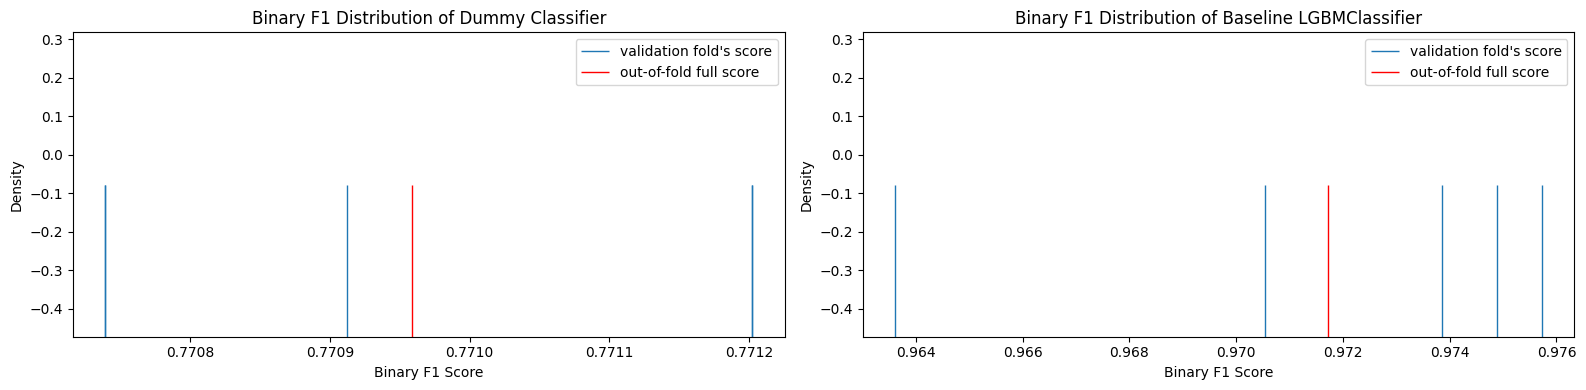

In [10]:
### Plot scores
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.rugplot(x=dummy_history["binary_scores"], height=.5, label="validation fold's score")
sea.rugplot(x=[dummy_history["full_binary_score"]], color="red", height=.5, label="out-of-fold full score")
plt.xlabel("Binary F1 Score")
plt.ylabel("Density")
plt.title("Binary F1 Distribution of Dummy Classifier")
plt.legend()

plt.subplot(122)
sea.rugplot(x=baseline_lgbm_history["binary_scores"], height=.5, label="validation fold's score")
sea.rugplot(x=[baseline_lgbm_history["full_binary_score"]], color="red", height=.5, label="out-of-fold full score")
plt.xlabel("Binary F1 Score")
plt.ylabel("Density")
plt.title("Binary F1 Distribution of Baseline LGBMClassifier")
plt.legend()

plt.tight_layout()
plt.show()

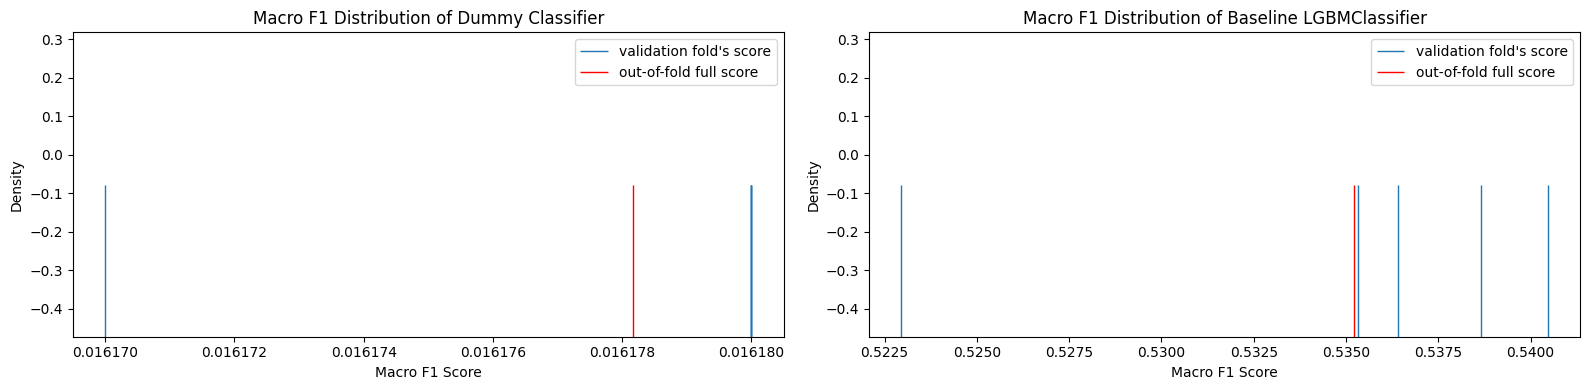

In [11]:
### Plot scores
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.rugplot(x=np.round(dummy_history["macro_scores"], 5), height=.5, label="validation fold's score")
sea.rugplot(x=[dummy_history["full_macro_score"]], color="red", height=.5, label="out-of-fold full score")
plt.xlabel("Macro F1 Score")
plt.ylabel("Density")
plt.title("Macro F1 Distribution of Dummy Classifier")
plt.legend()

plt.subplot(122)
sea.rugplot(x=baseline_lgbm_history["macro_scores"], height=.5, label="validation fold's score")
sea.rugplot(x=[baseline_lgbm_history["full_macro_score"]], color="red", height=.5, label="out-of-fold full score")
plt.xlabel("Macro F1 Score")
plt.ylabel("Density")
plt.title("Macro F1 Distribution of Baseline LGBMClassifier")
plt.legend()

plt.tight_layout()
plt.show()

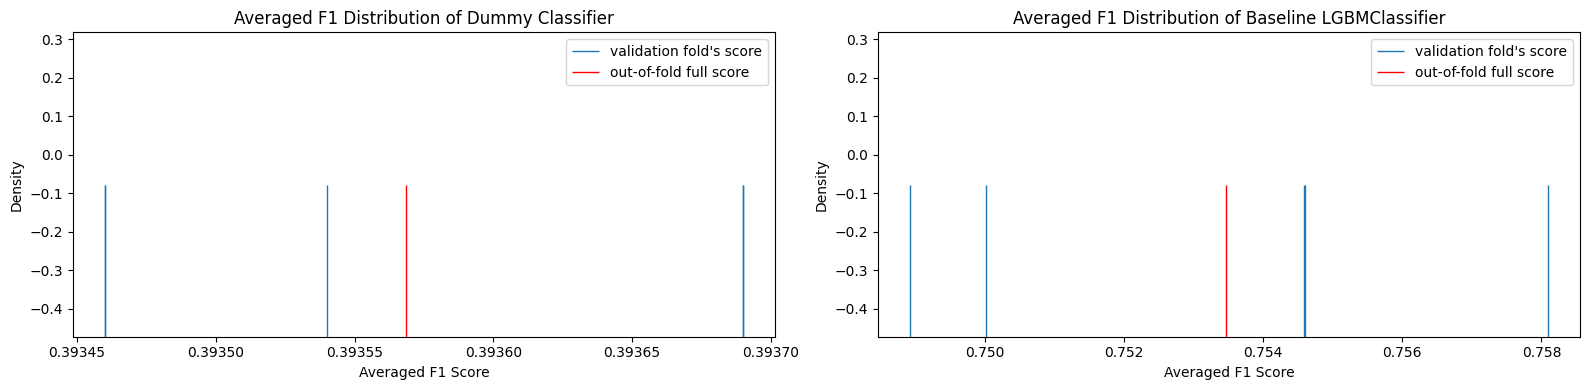

In [12]:
### Plot scores
plt.figure(figsize=(16,4))
plt.subplot(121)
sea.rugplot(x=np.round(dummy_history["weighted_scores"], 5), height=.5, label="validation fold's score")
sea.rugplot(x=[dummy_history["full_weighted_score"]], color="red", height=.5, label="out-of-fold full score")
plt.xlabel("Averaged F1 Score")
plt.ylabel("Density")
plt.title("Averaged F1 Distribution of Dummy Classifier")
plt.legend()

plt.subplot(122)
sea.rugplot(x=baseline_lgbm_history["weighted_scores"], height=.5, label="validation fold's score")
sea.rugplot(x=[baseline_lgbm_history["full_weighted_score"]], color="red", height=.5, label="out-of-fold full score")
plt.xlabel("Averaged F1 Score")
plt.ylabel("Density")
plt.title("Averaged F1 Distribution of Baseline LGBMClassifier")
plt.legend()

plt.tight_layout()
plt.show()

## Optuna 

In [13]:
def optuna_cv(model, model_kind, X, y, lbl_encoder, n_splits=5, 
             random_state=SEED, stopping_rounds=100, min_delta=.0005):
    
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    weighted_scores = []
    
    for fold_num,(train_fold, val_fold) in enumerate(skfold.split(X, y)):
        print(f"\nFold {fold_num + 1}/{n_splits}")
        X_train, y_train = X.iloc[train_fold], y[train_fold]
        X_val, y_val     = X.iloc[val_fold], y[val_fold]

        ## Makes clone of model
        cloned_model = clone(model)

        ## Trains appropriate model
        if model_kind=="lgbm":
            cloned_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lightgbm.early_stopping(stopping_rounds=stopping_rounds, min_delta=min_delta, verbose=-1)]
            )
        else:
            cloned_model.fit(X_train, y_train)

        ## Makes prediction
        y_pred = cloned_model.predict(X_val)
        
        ## Store cv score
        weighted_score = F1_score(y_val, y_pred, lbl_encoder, choice="weighted_score")
        weighted_scores.append(weighted_score)
    
    return np.mean(weighted_scores)

In [14]:
def lgbm_objective(trial):
    ## Initialize parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', .0125, 0.125, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 2**3, 2**8, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 15, 75),
        'subsample': trial.suggest_float('subsample', .5, .9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', .5, .9),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-7, 1e-2, log=True),
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-7, 1e-2, log=True) 
    }
    stopping_rounds = trial.suggest_int("stopping_rounds", 25, 150, step=25)
    min_delta = trial.suggest_float("min_delta", 5e-5, 1e-3, log=True)
    params["class_weight"] = "balanced"
    params["objective"] = "multiclass"
    params["n_jobs"] = -1
    params["verbose"] = -1
    params["random_state"] = SEED

    ## Initializes model and obtains performance
    model = LGBMClassifier(**params)
    score =  optuna_cv(model, "lgbm", X, y, label_encoder, n_splits=5, 
                       random_state=SEED, stopping_rounds=stopping_rounds, min_delta=min_delta)
    return score

In [15]:
sampler = optuna.samplers.TPESampler(seed=SEED)  
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(lgbm_objective, n_trials=300, timeout=10800) 

[I 2025-06-13 21:30:45,956] A new study created in memory with name: no-name-4ee18da2-d61b-4ea8-8c84-0dccb69750d4



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[157]	valid_0's multi_logloss: 1.0908

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 1.09621

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 1.09977

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 1.09124

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 1.15485


[I 2025-06-13 21:35:08,093] Trial 0 finished with value: 0.7613740267121528 and parameters: {'n_estimators': 2173, 'learning_rate': 0.04446938960009721, 'max_depth': 9, 'num_leaves': 100, 'min_child_samples': 73, 'subsample': 0.516713697184874, 'colsample_bytree': 0.8057247487178438, 'reg_lambda': 0.000572969048829653, 'reg_alpha': 1.482347281359505e-06, 'stopping_rounds': 75, 'min_delta': 5.352677523687092e-05}. Best is trial 0 with value: 0.7613740267121528.



Fold 1/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[310]	valid_0's multi_logloss: 1.11712

Fold 2/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 1.12259

Fold 3/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[354]	valid_0's multi_logloss: 1.09471

Fold 4/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 1.12205

Fold 5/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 1.16708


[I 2025-06-13 21:36:36,809] Trial 1 finished with value: 0.7537024264069893 and parameters: {'n_estimators': 1119, 'learning_rate': 0.07761087409236457, 'max_depth': 3, 'num_leaves': 245, 'min_child_samples': 60, 'subsample': 0.6192326816776991, 'colsample_bytree': 0.5020281098115027, 'reg_lambda': 1.1972599158734124e-07, 'reg_alpha': 0.0003480052904731114, 'stopping_rounds': 125, 'min_delta': 0.0005388037356427951}. Best is trial 0 with value: 0.7613740267121528.



Fold 1/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 1.15833

Fold 2/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 1.1299

Fold 3/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.13209

Fold 4/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 1.13856

Fold 5/5
Training until validation scores don't improve for 25 rounds


[I 2025-06-13 21:37:54,151] Trial 2 finished with value: 0.7578782294658948 and parameters: {'n_estimators': 539, 'learning_rate': 0.09220403118299544, 'max_depth': 9, 'num_leaves': 31, 'min_child_samples': 31, 'subsample': 0.7948995425592571, 'colsample_bytree': 0.5482522843656776, 'reg_lambda': 2.626267599028431e-06, 'reg_alpha': 0.002248390918460692, 'stopping_rounds': 25, 'min_delta': 0.00011976460236792266}. Best is trial 0 with value: 0.7613740267121528.


Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.19978

Fold 1/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 1.1508

Fold 2/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 1.13925

Fold 3/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 1.13795

Fold 4/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.12949

Fold 5/5
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 1.19427


[I 2025-06-13 21:39:42,976] Trial 3 finished with value: 0.753903159324437 and parameters: {'n_estimators': 286, 'learning_rate': 0.07504890428483249, 'max_depth': 9, 'num_leaves': 184, 'min_child_samples': 38, 'subsample': 0.7295910825075778, 'colsample_bytree': 0.629531657670085, 'reg_lambda': 1.1164660815456925e-05, 'reg_alpha': 0.0020056036049101293, 'stopping_rounds': 25, 'min_delta': 0.00013018999718304733}. Best is trial 0 with value: 0.7613740267121528.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[811]	valid_0's multi_logloss: 1.10558

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[717]	valid_0's multi_logloss: 1.11073

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	valid_0's multi_logloss: 1.0938

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[886]	valid_0's multi_logloss: 1.10806

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	valid_0's multi_logloss: 1.1782


[I 2025-06-13 21:48:00,047] Trial 4 finished with value: 0.7623353411878286 and parameters: {'n_estimators': 1487, 'learning_rate': 0.013674646766903296, 'max_depth': 6, 'num_leaves': 12, 'min_child_samples': 24, 'subsample': 0.8871968860334765, 'colsample_bytree': 0.760682676625448, 'reg_lambda': 1.3026326899874972e-06, 'reg_alpha': 3.1638208989499744e-06, 'stopping_rounds': 100, 'min_delta': 0.00018012035917872295}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 1.16798

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 1.14166

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 1.14936

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 1.1455

Fold 5/5
Training until validation scores don't improve for 100 rounds


[I 2025-06-13 21:49:41,147] Trial 5 finished with value: 0.7496043870498916 and parameters: {'n_estimators': 238, 'learning_rate': 0.11372379724134808, 'max_depth': 6, 'num_leaves': 18, 'min_child_samples': 47, 'subsample': 0.7919136117786403, 'colsample_bytree': 0.6665870447369492, 'reg_lambda': 4.694021516020324e-05, 'reg_alpha': 5.54129145990139e-07, 'stopping_rounds': 100, 'min_delta': 0.0001409313905796219}. Best is trial 4 with value: 0.7623353411878286.


Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 1.19046

Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 1.11983

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 1.12758

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 1.09823

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[165]	valid_0's multi_logloss: 1.10615

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 1.19178


[I 2025-06-13 21:51:19,085] Trial 6 finished with value: 0.7581667135767376 and parameters: {'n_estimators': 286, 'learning_rate': 0.07990599050618753, 'max_depth': 5, 'num_leaves': 33, 'min_child_samples': 46, 'subsample': 0.6123366979789767, 'colsample_bytree': 0.5354802489465474, 'reg_lambda': 0.0006476133418150925, 'reg_alpha': 3.5630838328254836e-06, 'stopping_rounds': 75, 'min_delta': 0.00015138315124063874}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 1.11294

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 1.12341

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 1.12286

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's multi_logloss: 1.13567

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 1.16223


[I 2025-06-13 21:54:36,179] Trial 7 finished with value: 0.7547254950292361 and parameters: {'n_estimators': 2979, 'learning_rate': 0.07982162897776736, 'max_depth': 9, 'num_leaves': 76, 'min_child_samples': 64, 'subsample': 0.851839202827913, 'colsample_bytree': 0.8347792749749607, 'reg_lambda': 3.722083499537664e-05, 'reg_alpha': 0.00033183217915297143, 'stopping_rounds': 100, 'min_delta': 0.0005595656190038463}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 1.19933

Fold 2/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 1.19869

Fold 3/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 1.19224

Fold 4/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 1.18116

Fold 5/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 1.25105


[I 2025-06-13 21:58:43,779] Trial 8 finished with value: 0.7498254449883521 and parameters: {'n_estimators': 947, 'learning_rate': 0.09406003415877973, 'max_depth': 10, 'num_leaves': 76, 'min_child_samples': 23, 'subsample': 0.545965338079401, 'colsample_bytree': 0.7915474846347614, 'reg_lambda': 0.00012693549923462383, 'reg_alpha': 1.2639023713166334e-05, 'stopping_rounds': 150, 'min_delta': 8.925798355320911e-05}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 1.13825

Fold 2/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 1.13352

Fold 3/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 1.13345

Fold 4/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 1.14265

Fold 5/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's multi_logloss: 1.19525


[I 2025-06-13 21:59:53,415] Trial 9 finished with value: 0.7466339299274527 and parameters: {'n_estimators': 104, 'learning_rate': 0.05284735110353609, 'max_depth': 6, 'num_leaves': 105, 'min_child_samples': 56, 'subsample': 0.5760600771913582, 'colsample_bytree': 0.60884552518417, 'reg_lambda': 1.6523858407823062e-05, 'reg_alpha': 7.004893711147589e-07, 'stopping_rounds': 125, 'min_delta': 0.000112901823067405}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1072]	valid_0's multi_logloss: 1.1169

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1003]	valid_0's multi_logloss: 1.12107

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1092]	valid_0's multi_logloss: 1.09604

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1249]	valid_0's multi_logloss: 1.12251

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1000]	valid_0's multi_logloss: 1.18572


[I 2025-06-13 22:07:59,866] Trial 10 finished with value: 0.7568818452280894 and parameters: {'n_estimators': 1448, 'learning_rate': 0.01411761561367356, 'max_depth': 12, 'num_leaves': 8, 'min_child_samples': 15, 'subsample': 0.8973366451486467, 'colsample_bytree': 0.7298013801911386, 'reg_lambda': 4.681319189129051e-07, 'reg_alpha': 1.4053274872318018e-07, 'stopping_rounds': 50, 'min_delta': 0.00029220676944601676}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[680]	valid_0's multi_logloss: 1.10914

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[516]	valid_0's multi_logloss: 1.1206

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[767]	valid_0's multi_logloss: 1.09165

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[758]	valid_0's multi_logloss: 1.09653

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[501]	valid_0's multi_logloss: 1.18151


[I 2025-06-13 22:13:31,866] Trial 11 finished with value: 0.7571824752124316 and parameters: {'n_estimators': 2673, 'learning_rate': 0.024266834465095186, 'max_depth': 7, 'num_leaves': 8, 'min_child_samples': 73, 'subsample': 0.685724130591427, 'colsample_bytree': 0.8976195304672864, 'reg_lambda': 0.00765837645917984, 'reg_alpha': 5.124882564407685e-06, 'stopping_rounds': 75, 'min_delta': 5.510495115073536e-05}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[443]	valid_0's multi_logloss: 1.09602

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[437]	valid_0's multi_logloss: 1.11145

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's multi_logloss: 1.10066

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[546]	valid_0's multi_logloss: 1.10285

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid_0's multi_logloss: 1.16464


[I 2025-06-13 22:16:51,168] Trial 12 finished with value: 0.7590929396109033 and parameters: {'n_estimators': 1822, 'learning_rate': 0.03262258305315243, 'max_depth': 4, 'num_leaves': 16, 'min_child_samples': 75, 'subsample': 0.5248312412261793, 'colsample_bytree': 0.7520091841508054, 'reg_lambda': 0.0010621433410301178, 'reg_alpha': 5.012130800842941e-05, 'stopping_rounds': 50, 'min_delta': 5.045962661379665e-05}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	valid_0's multi_logloss: 1.13766

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's multi_logloss: 1.13598

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's multi_logloss: 1.13535

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's multi_logloss: 1.13082

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[318]	valid_0's multi_logloss: 1.1859


[I 2025-06-13 22:32:38,295] Trial 13 finished with value: 0.7564892157325785 and parameters: {'n_estimators': 702, 'learning_rate': 0.014468116492906807, 'max_depth': 11, 'num_leaves': 125, 'min_child_samples': 31, 'subsample': 0.6911792542370003, 'colsample_bytree': 0.8306730360241403, 'reg_lambda': 1.8261852893713503e-06, 'reg_alpha': 8.195706142628383e-07, 'stopping_rounds': 100, 'min_delta': 0.00027234451855616333}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[239]	valid_0's multi_logloss: 1.09715

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[242]	valid_0's multi_logloss: 1.10428

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[255]	valid_0's multi_logloss: 1.1029

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 1.0955

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 1.16269


[I 2025-06-13 22:38:28,967] Trial 14 finished with value: 0.7592086294531488 and parameters: {'n_estimators': 2019, 'learning_rate': 0.025419190183234727, 'max_depth': 8, 'num_leaves': 46, 'min_child_samples': 53, 'subsample': 0.7672489531806909, 'colsample_bytree': 0.7791000125155915, 'reg_lambda': 0.00038537440254300047, 'reg_alpha': 4.3612182851979314e-05, 'stopping_rounds': 75, 'min_delta': 0.0009948455826276528}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 1.12203

Fold 2/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[189]	valid_0's multi_logloss: 1.11638

Fold 3/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[217]	valid_0's multi_logloss: 1.10356

Fold 4/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[226]	valid_0's multi_logloss: 1.12731

Fold 5/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[163]	valid_0's multi_logloss: 1.18673


[I 2025-06-13 22:42:02,806] Trial 15 finished with value: 0.754652979890848 and parameters: {'n_estimators': 585, 'learning_rate': 0.04795315995066525, 'max_depth': 7, 'num_leaves': 16, 'min_child_samples': 16, 'subsample': 0.6540608865072307, 'colsample_bytree': 0.6927708877554071, 'reg_lambda': 0.006554502035003612, 'reg_alpha': 1.1395912544964752e-07, 'stopping_rounds': 125, 'min_delta': 7.806479735457946e-05}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[456]	valid_0's multi_logloss: 1.11064

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's multi_logloss: 1.12116

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[515]	valid_0's multi_logloss: 1.10781

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[512]	valid_0's multi_logloss: 1.11862

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_logloss: 1.18525


[I 2025-06-13 22:47:56,909] Trial 16 finished with value: 0.7545486984348636 and parameters: {'n_estimators': 1327, 'learning_rate': 0.02066937921212966, 'max_depth': 5, 'num_leaves': 50, 'min_child_samples': 38, 'subsample': 0.8632001594636078, 'colsample_bytree': 0.8687612601294241, 'reg_lambda': 4.5668538946211455e-06, 'reg_alpha': 3.1282370168316313e-06, 'stopping_rounds': 50, 'min_delta': 0.00020094201945387524}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 1.10056

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	valid_0's multi_logloss: 1.09891

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's multi_logloss: 1.10818

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 1.09441

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 1.15879


[I 2025-06-13 22:52:41,812] Trial 17 finished with value: 0.7591359213670921 and parameters: {'n_estimators': 1917, 'learning_rate': 0.03704089539274714, 'max_depth': 8, 'num_leaves': 136, 'min_child_samples': 65, 'subsample': 0.5011327761606154, 'colsample_bytree': 0.8055525237317459, 'reg_lambda': 5.112473870574771e-07, 'reg_alpha': 1.904501773314247e-05, 'stopping_rounds': 100, 'min_delta': 0.00021478082371731511}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[113]	valid_0's multi_logloss: 1.13032

Fold 2/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 1.13225

Fold 3/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 1.12496

Fold 4/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 1.12919

Fold 5/5
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 1.19301


[I 2025-06-13 22:56:43,920] Trial 18 finished with value: 0.7532654483943867 and parameters: {'n_estimators': 826, 'learning_rate': 0.05510999337130016, 'max_depth': 11, 'num_leaves': 24, 'min_child_samples': 25, 'subsample': 0.8320782447777275, 'colsample_bytree': 0.7334277405551818, 'reg_lambda': 0.0017740832575445012, 'reg_alpha': 1.598108454967352e-06, 'stopping_rounds': 150, 'min_delta': 0.0003545065923363286}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[465]	valid_0's multi_logloss: 1.11205

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[438]	valid_0's multi_logloss: 1.11088

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[444]	valid_0's multi_logloss: 1.10551

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[483]	valid_0's multi_logloss: 1.1124

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[399]	valid_0's multi_logloss: 1.16545


[I 2025-06-13 23:03:03,437] Trial 19 finished with value: 0.758424919378493 and parameters: {'n_estimators': 2215, 'learning_rate': 0.018057471373284582, 'max_depth': 6, 'num_leaves': 67, 'min_child_samples': 39, 'subsample': 0.73152305114726, 'colsample_bytree': 0.6920882439977584, 'reg_lambda': 0.0001645120195533117, 'reg_alpha': 9.581621508105273e-05, 'stopping_rounds': 75, 'min_delta': 6.843436754458299e-05}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[808]	valid_0's multi_logloss: 1.1147

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[629]	valid_0's multi_logloss: 1.13945

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[669]	valid_0's multi_logloss: 1.09799

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[706]	valid_0's multi_logloss: 1.12539

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[565]	valid_0's multi_logloss: 1.17719


[I 2025-06-13 23:06:46,587] Trial 20 finished with value: 0.7522993228858613 and parameters: {'n_estimators': 1473, 'learning_rate': 0.03129940463754268, 'max_depth': 3, 'num_leaves': 12, 'min_child_samples': 51, 'subsample': 0.5794869696860573, 'colsample_bytree': 0.8461325889219944, 'reg_lambda': 1.1264369362008843e-07, 'reg_alpha': 0.009746491987285482, 'stopping_rounds': 50, 'min_delta': 0.0004422132822495678}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 1.08708

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[254]	valid_0's multi_logloss: 1.09794

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 1.09041

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[303]	valid_0's multi_logloss: 1.09218

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[242]	valid_0's multi_logloss: 1.15123


[I 2025-06-13 23:12:11,994] Trial 21 finished with value: 0.7606034625834657 and parameters: {'n_estimators': 2094, 'learning_rate': 0.02578843509298548, 'max_depth': 8, 'num_leaves': 42, 'min_child_samples': 67, 'subsample': 0.7713993198602533, 'colsample_bytree': 0.7774626111124336, 'reg_lambda': 0.00026378614896507575, 'reg_alpha': 7.691372709612616e-06, 'stopping_rounds': 75, 'min_delta': 0.0008947003170286}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[388]	valid_0's multi_logloss: 1.0746

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[403]	valid_0's multi_logloss: 1.09679

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[449]	valid_0's multi_logloss: 1.08431

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[474]	valid_0's multi_logloss: 1.08457

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[376]	valid_0's multi_logloss: 1.14823


[I 2025-06-13 23:19:34,048] Trial 22 finished with value: 0.7602862114758437 and parameters: {'n_estimators': 2754, 'learning_rate': 0.01701682344309872, 'max_depth': 8, 'num_leaves': 34, 'min_child_samples': 68, 'subsample': 0.8875491562485052, 'colsample_bytree': 0.7644502840210955, 'reg_lambda': 0.00018679029439277808, 'reg_alpha': 8.559283904944884e-06, 'stopping_rounds': 75, 'min_delta': 0.0009896014658215694}. Best is trial 4 with value: 0.7623353411878286.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[508]	valid_0's multi_logloss: 1.07866

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's multi_logloss: 1.08998

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[503]	valid_0's multi_logloss: 1.0855

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[568]	valid_0's multi_logloss: 1.08191

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's multi_logloss: 1.14985


[I 2025-06-13 23:30:18,540] Trial 23 finished with value: 0.763139819038873 and parameters: {'n_estimators': 1601, 'learning_rate': 0.012502527035230948, 'max_depth': 10, 'num_leaves': 56, 'min_child_samples': 70, 'subsample': 0.819484245856843, 'colsample_bytree': 0.8043769543397135, 'reg_lambda': 0.0031523588243255293, 'reg_alpha': 3.094663101246672e-07, 'stopping_rounds': 100, 'min_delta': 0.0006180506283718214}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 1.08196

Fold 2/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[438]	valid_0's multi_logloss: 1.10026

Fold 3/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[439]	valid_0's multi_logloss: 1.09948

Fold 4/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[437]	valid_0's multi_logloss: 1.08974

Fold 5/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[435]	valid_0's multi_logloss: 1.15313


[I 2025-06-13 23:38:22,638] Trial 24 finished with value: 0.757546603491069 and parameters: {'n_estimators': 442, 'learning_rate': 0.012619105647439201, 'max_depth': 11, 'num_leaves': 59, 'min_child_samples': 71, 'subsample': 0.8252424196360045, 'colsample_bytree': 0.8123644313086912, 'reg_lambda': 0.003133151117468254, 'reg_alpha': 3.0259543548367533e-07, 'stopping_rounds': 125, 'min_delta': 0.0006804167092570425}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's multi_logloss: 1.11891

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 1.11161

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 1.1221

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 1.10431

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 1.16886


[I 2025-06-13 23:43:12,323] Trial 25 finished with value: 0.7577737906164438 and parameters: {'n_estimators': 1107, 'learning_rate': 0.04379019485278034, 'max_depth': 10, 'num_leaves': 91, 'min_child_samples': 60, 'subsample': 0.8635231128688515, 'colsample_bytree': 0.8618422621448844, 'reg_lambda': 0.0024212601113292867, 'reg_alpha': 1.8407438795269805e-06, 'stopping_rounds': 100, 'min_delta': 0.00018557416253723103}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's multi_logloss: 1.0783

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's multi_logloss: 1.09622

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's multi_logloss: 1.09576

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's multi_logloss: 1.08499

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's multi_logloss: 1.15244


[I 2025-06-13 23:51:48,516] Trial 26 finished with value: 0.7594820658212992 and parameters: {'n_estimators': 1501, 'learning_rate': 0.017074840727022336, 'max_depth': 10, 'num_leaves': 161, 'min_child_samples': 61, 'subsample': 0.806488228353325, 'colsample_bytree': 0.7253464084500004, 'reg_lambda': 6.128485391032119e-05, 'reg_alpha': 3.4816066173144697e-07, 'stopping_rounds': 100, 'min_delta': 0.00038137851547786095}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[942]	valid_0's multi_logloss: 1.10004

Fold 2/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[845]	valid_0's multi_logloss: 1.11094

Fold 3/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[874]	valid_0's multi_logloss: 1.09073

Fold 4/5
Training until validation scores don't improve for 125 rounds
Did not meet early stopping. Best iteration is:
[1062]	valid_0's multi_logloss: 1.09883

Fold 5/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[746]	valid_0's multi_logloss: 1.17159


[I 2025-06-14 00:01:12,262] Trial 27 finished with value: 0.7582046471210176 and parameters: {'n_estimators': 1075, 'learning_rate': 0.012944515042592992, 'max_depth': 12, 'num_leaves': 11, 'min_child_samples': 70, 'subsample': 0.7362216055825691, 'colsample_bytree': 0.8846350870109971, 'reg_lambda': 0.0007571256055243533, 'reg_alpha': 1.4643470436370924e-06, 'stopping_rounds': 125, 'min_delta': 0.00010103346044915169}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 1.11693

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 1.09984

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 1.11158

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	valid_0's multi_logloss: 1.0922

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 1.15688


[I 2025-06-14 00:03:57,725] Trial 28 finished with value: 0.7571927497500148 and parameters: {'n_estimators': 771, 'learning_rate': 0.06136548711735825, 'max_depth': 7, 'num_leaves': 22, 'min_child_samples': 75, 'subsample': 0.6378275279596228, 'colsample_bytree': 0.8191409556847522, 'reg_lambda': 0.009782804501489849, 'reg_alpha': 1.7377757855552607e-07, 'stopping_rounds': 100, 'min_delta': 0.0002608987494311041}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[305]	valid_0's multi_logloss: 1.08759

Fold 2/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[273]	valid_0's multi_logloss: 1.09725

Fold 3/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[314]	valid_0's multi_logloss: 1.09612

Fold 4/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[375]	valid_0's multi_logloss: 1.08775

Fold 5/5
Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 1.15634


[I 2025-06-14 00:11:26,688] Trial 29 finished with value: 0.7588254514721074 and parameters: {'n_estimators': 1647, 'learning_rate': 0.020749437298195287, 'max_depth': 9, 'num_leaves': 225, 'min_child_samples': 59, 'subsample': 0.8359534496285244, 'colsample_bytree': 0.6616349535947654, 'reg_lambda': 0.003342581891393605, 'reg_alpha': 3.16725158587856e-07, 'stopping_rounds': 125, 'min_delta': 0.0005597279073531592}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[156]	valid_0's multi_logloss: 1.14009

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 1.13689

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 1.12641

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[139]	valid_0's multi_logloss: 1.13707

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[132]	valid_0's multi_logloss: 1.19224


[I 2025-06-14 00:17:24,216] Trial 30 finished with value: 0.7563717132396671 and parameters: {'n_estimators': 1288, 'learning_rate': 0.03667896729076117, 'max_depth': 10, 'num_leaves': 110, 'min_child_samples': 32, 'subsample': 0.8848886077325051, 'colsample_bytree': 0.7486279258610518, 'reg_lambda': 9.165110388934669e-07, 'reg_alpha': 1.0309954729806008e-06, 'stopping_rounds': 75, 'min_delta': 0.00017182722216619665}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 1.09357

Fold 2/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[232]	valid_0's multi_logloss: 1.09602

Fold 3/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 1.09384

Fold 4/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 1.08612

Fold 5/5
Training until validation scores don't improve for 75 rounds
Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.15946


[I 2025-06-14 00:22:24,140] Trial 31 finished with value: 0.7585522468512627 and parameters: {'n_estimators': 2201, 'learning_rate': 0.027286794109652235, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 67, 'subsample': 0.7652713082912613, 'colsample_bytree': 0.7813570888749092, 'reg_lambda': 0.0002792126480899983, 'reg_alpha': 5.689773708275408e-06, 'stopping_rounds': 75, 'min_delta': 0.0008148045250780043}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[291]	valid_0's multi_logloss: 1.08558

Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid_0's multi_logloss: 1.09799

Fold 3/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[312]	valid_0's multi_logloss: 1.10046

Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's multi_logloss: 1.08501

Fold 5/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 1.16022


[I 2025-06-14 00:28:24,859] Trial 32 finished with value: 0.7598298965015046 and parameters: {'n_estimators': 2459, 'learning_rate': 0.021689741810525204, 'max_depth': 9, 'num_leaves': 39, 'min_child_samples': 64, 'subsample': 0.7823856123418962, 'colsample_bytree': 0.7901942966597059, 'reg_lambda': 0.00010042826447518251, 'reg_alpha': 2.161370903152785e-05, 'stopping_rounds': 50, 'min_delta': 0.0007654813930880208}. Best is trial 23 with value: 0.763139819038873.



Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[763]	valid_0's multi_logloss: 1.09491

Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[658]	valid_0's multi_logloss: 1.10198

Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[667]	valid_0's multi_logloss: 1.09256

Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[760]	valid_0's multi_logloss: 1.1037

Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[628]	valid_0's multi_logloss: 1.16396


[I 2025-06-14 00:35:59,926] Trial 33 finished with value: 0.755954747181512 and parameters: {'n_estimators': 1818, 'learning_rate': 0.015322362562206244, 'max_depth': 5, 'num_leaves': 25, 'min_child_samples': 70, 'subsample': 0.8116907410457788, 'colsample_bytree': 0.7111906804046543, 'reg_lambda': 0.0004616806021190103, 'reg_alpha': 2.5190255537774854e-06, 'stopping_rounds': 100, 'min_delta': 0.0004593490267516708}. Best is trial 23 with value: 0.763139819038873.


In [16]:
# Best result
print("Best score (objective value):", study.best_value)
print("Best trial:")
print(study.best_trial.params)

joblib.dump(study.best_params, "baseline_lgbm_params.joblib")

Best score (objective value): 0.763139819038873
Best trial:
{'n_estimators': 1601, 'learning_rate': 0.012502527035230948, 'max_depth': 10, 'num_leaves': 56, 'min_child_samples': 70, 'subsample': 0.819484245856843, 'colsample_bytree': 0.8043769543397135, 'reg_lambda': 0.0031523588243255293, 'reg_alpha': 3.094663101246672e-07, 'stopping_rounds': 100, 'min_delta': 0.0006180506283718214}


['baseline_lgbm_params.joblib']